# Imports

In [67]:
import os
import base64
import joblib
import pandas as pd
import numpy as np
import category_encoders as ce
import json
import joblib
import pickle
import math
import requests
from copy import deepcopy
import seaborn as sns
from uuid import uuid4

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, power_transform, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (precision_score,
                            recall_score,
                            f1_score,
                            accuracy_score,
                            roc_auc_score,
                            confusion_matrix,
                            ConfusionMatrixDisplay,
                            make_scorer,
                            RocCurveDisplay,
                            auc,
                            roc_curve,
                            precision_recall_curve)

from sklearn.base import BaseEstimator, TransformerMixin

from pandas_profiling import ProfileReport

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('ggplot')
%matplotlib inline

# Custom transformer imports

In [2]:
# WIP preprocessor which assigns categories and compresses some code
from custom_transformers.preprocessor import ColumnConverter

# WIP ordinal category preprocessor
from custom_transformers.custom_ordinal_encoder import custom_oe

#WIP column selector
from custom_transformers.featureselector import SelectColumns

# WIP onehot category preprocessor
from custom_transformers.custom_onehot_encoder import custom_one_hot

# WIP onehot category preprocessor
from custom_transformers.custom_impute_scale import custom_impute_scale


# Functions

In [3]:
def load_train_data():
    df = pd.read_csv(os.path.join("data", "train_data.csv"))
    return df

data_train = load_train_data()

In [4]:
def assign_index(df, indexcol: str):
    _df = df.copy()
    _df = _df.set_index(indexcol)
    return _df

In [5]:
def build_target(df, target: str):
    _df = df.copy()
    _df[target] = np.where(_df[target]== 'Yes', True, False)
    return _df

# Function to test if we satisfied requirements:

The first step will make a copy of the X_test and apply the custom converter for the columns - it will update the categories we are interested in (avoid duplicates etc)

In [6]:
def verify_no_discrimination_2(X_test,
                               y_true,
                               y_pred,
                               sensitive_columns = [],
                               max_diff=0.1,
                               average='weighted',
                               min_samples=50):    
    # This time with precision
    
    _df = X_test.copy()
    
    results = {}
    
    cc = ColumnConverter()
    _df = cc.fit_transform(_df)
    
    for column in sensitive_columns:  
        sensitive_classes = _df[column].unique()
        is_satisfied = True
        precision_scores = {}
        
        for sensitive_class in sensitive_classes:
            mask = (_df[column] == sensitive_class)
            if np.sum(mask) > min_samples:
                precision_scores[sensitive_class] = precision_score(y_true[mask],
                                                      y_pred[mask],
                                                      pos_label=1,
                                                      labels=np.unique(y_pred[mask]))
        
        diff = np.max(list(precision_scores.values())) - np.min(list(precision_scores.values()))
        if diff > max_diff:
            is_satisfied = False
        
        results[column] = [precision_scores, diff, is_satisfied]
    
    return results

# Loading data

In [7]:
target = 'readmitted'
index_col = 'admission_id'

In [8]:
data_train = load_train_data()
data_train = assign_index(data_train, index_col)
data_train = build_target(data_train, target)

In [9]:
#List of all features (n=numerical, uc=unordered actegory, oc=ordered category, b=boolean)

all_features = ['patient_id', #identifier
                'race', #uc
                'gender', #uc
                'age', #oc
                'weight', #oc               
                'admission_type_code', #uc
                'discharge_disposition_code', #uc
                'admission_source_code', #uc
                'time_in_hospital', #n
                'payer_code', #uc
                'medical_specialty', #uc
                'has_prosthesis', #b
                'complete_vaccination_status', #uc
                'num_lab_procedures', #n
                'num_procedures', #n
                'num_medications', #n
                'number_outpatient', #n
                'number_emergency', #n
                'number_inpatient', #n
                'diag_1', #uc
                'diag_2', #uc
                'diag_3', #uc
                'number_diagnoses', #n
                'blood_type', #uc
                'hemoglobin_level', #n
                'blood_transfusion', #b
                'max_glu_serum', #oc
                'A1Cresult', #oc
                'diuretics', #b
                'insulin', #b
                'change', #b
                'diabetesMed'] #b]

num_features = ['time_in_hospital', 
                'num_lab_procedures',
                'num_procedures',
                'num_medications',
                'number_outpatient',
                'number_emergency',
                'number_inpatient',
                'number_diagnoses',
                'hemoglobin_level']

bool_features = ['has_prosthesis',
                 'blood_transfusion',
                 'diuretics',
                 'insulin',
                 'change',
                 'diabetesMed']

cat_features = ['race',
                'gender',
                'admission_type_code', 
                'discharge_disposition_code',
                'admission_source_code', 
                'payer_code',
                'medical_specialty',
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type']

ord_cat_features = ['age',
                    'weight',
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

# missing features: date of admission and date of release

### Test train split

In [10]:
# Convert target to boolean

# We have a small portion kept aside because of our random undersampling approach where we lose a lot of train data 
#df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=data_train[target])

df_train, df_test = train_test_split(data_train, test_size=0.1, random_state=42, stratify=None, shuffle=False)

### Dealing with unbalanced train data:
1. Going to use random oversampling

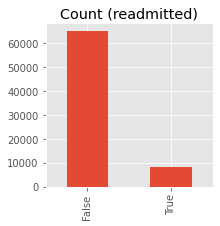

In [11]:
plt.rcParams["figure.figsize"] = [3, 3]
df_train[target].value_counts().plot(kind='bar', title='Count (readmitted)');

In [12]:
# get counts and split tables
count_f, count_t = df_train[target].value_counts()
df_f = df_train[df_train[target] == False]
df_t = df_train[df_train[target] == True]

### Random oversampling of the positive (True) class

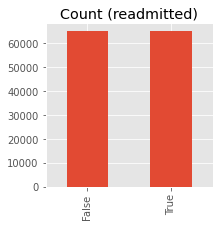

In [13]:
# oversampling (lots of duplication of positive classes)
df_t_oversampled = df_t.sample(count_f, replace=True)
df_train_oversampled = pd.concat([df_t_oversampled, df_f], axis=0)
#sort it to maintain some kind of order
df_train_oversampled = df_train_oversampled.sort_index()
#plot it
df_train_oversampled[target].value_counts().plot(kind='bar', title='Count (readmitted)');

### Test train split and selection

In [14]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

# with random oversampling
#X_train = df_train_oversampled.drop(target, axis=1)
#y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [15]:
selected_features = ['time_in_hospital', 
                     'num_lab_procedures',
                     'num_procedures',
                     'num_medications',
                     'number_outpatient',
                     'number_emergency',
                     'number_inpatient',
                     'number_diagnoses',
                     'hemoglobin_level',
                     
                     #'has_prosthesis',
                     'blood_transfusion',
                     #'diuretics',
                     'insulin',
                     'change',
                     'diabetesMed',
                     
                     'race',
                     'gender',
                     'admission_type_code', 
                     'discharge_disposition_code',
                     'admission_source_code', 
                     'payer_code',
                     #'medical_specialty',
                     #'complete_vaccination_status',
                     'blood_type',
                     'diag_1',
                     'diag_2',
                     'diag_3',
                     
                     'max_glu_serum',
                     'A1Cresult',
                     'age',
                     #'weight'
                    ]

In [16]:
num_feats = [feat for feat in selected_features if feat in num_features]
cat_feats = [feat for feat in selected_features if feat in cat_features+bool_features+ord_cat_features]
bool_feats = [feat for feat in selected_features if feat in bool_features]
ord_cat_feats = [feat for feat in selected_features if feat in ord_cat_features]

In [17]:
ord_cat_features = ['age',
                    'weight', #lots of missing or unknown values
                    'max_glu_serum',
                    'A1Cresult',
                    'complete_vaccination_status',]

In [18]:
cat_features = ['race', #done
                'gender', #done
                'admission_type_code', #done 
                'discharge_disposition_code', #done
                'admission_source_code', # done 
                'payer_code', #done (now the insurance column)
                #'medical_specialty', #done (any specialty over 100 - lets see how bad it gets)
                'diag_1',
                'diag_2',
                'diag_3',
                'blood_type'
               ] #dropping blood type

1. Not using blood type
1. Not using weight
1. Not using diagnoses: probably linked to medical specialty
    1. Will be added in the next version
1. Admission source not yet included
1. Race, gender and payer code (SP=uninsured) will not be used to model

##### Processing Diagnoses:
1. High cardinality (and possibly redundant information due to overlpa with the speecialty?)

In [19]:
# This needs to become a custom pipeline - and we need different scalers here

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())]) #StandardScaler or MinMaxScaler
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', ce.OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_feats),
        ('cat', categorical_transformer, cat_features)],
remainder="passthrough",sparse_threshold=0)

# Random Forest

Grid search

In [20]:
# X = X_train.copy()
# y = y_train.copy()
# parameters = {
#     'max_depth': [2, 5, 10],
#     'max_features': ['auto', 'log2'],
#     'class_weight': ["balanced"],
#     'n_estimators': [10, 100, 1000],
#     'criterion': ['gini', 'entropy'],
#     'bootstrap': [True, False],
#     'min_samples_split': [2, 5, 10]
#              }

In [21]:
# grid_search_pipeline = make_pipeline(
#     ColumnConverter(), #Does quick clean up, assigns datatypes and categories
#     custom_oe(), #Handles encoding of ordinal variable
#     SelectColumns(cols=selected_features),
#     preprocessor, #uses preprocessor defined above
#     GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1),
#                            parameters,
#                            cv=5,
#                            scoring="f1",
#                            return_train_score=True))

In [22]:
# %%timeit -n 1 -r 1
# grid_search_pipeline.fit(X_train, y_train)
# grid_search_pipeline.named_steps.gridsearchcv
# grid_search_pipeline.named_steps.gridsearchcv.best_params_

Model

In [23]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RandomForestClassifier(max_depth=10,
                           class_weight="balanced",
                           random_state=42, n_jobs=-1,
                           n_estimators = 1000,
                           criterion = 'gini',
                           max_features = 'auto',
                           bootstrap = False),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28233438485804413
recall score: 0.618663594470046
precision score: 0.18290190735694822
discrimination results:


In [24]:
#verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [25]:
plt.rcParams["figure.figsize"] = [3, 3]

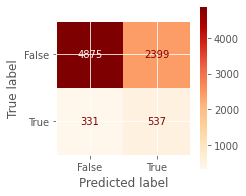

In [26]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

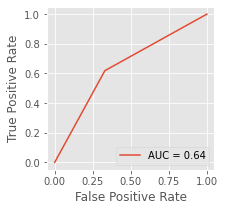

In [27]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

### Evaluation and setting threshold:
1. The client wants at least 50% to be correct

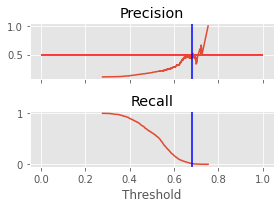

In [28]:
y_pred_probas = pipeline.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]
threshold_rq = thresholds[min_index]
y_pred = (y_pred_probas >= threshold_rq)
plt.rcParams["figure.figsize"] = [4, 3]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_probas)
precision = precision[:-1]
recall = recall[:-1]
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
plt.xlabel('Threshold')
ax1.set_title('Precision')
ax1.axvline(x=threshold_rq, color='blue')
ax2.set_title('Recall')
ax2.axvline(x=threshold_rq, color='blue')
fig.tight_layout()
plt.show()

In [29]:
print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.026905829596412554
recall score: 0.013824884792626729
precision score: 0.5
discrimination results:


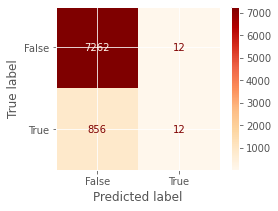

In [30]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

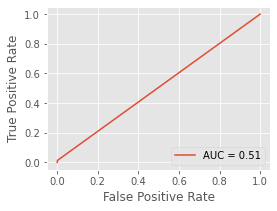

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

In [32]:
raise NotImplementedError()

NotImplementedError: 

# Gradient Boosting

Creating weighted samples to balance the dataset

In [43]:
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 8

Grid search

In [44]:
parameters = {
    'loss': ['deviance', 'exponential'],
    'learning_rate': [0.1, 0.2,],
    'n_estimators': [10],
    'subsample': [0.1, 0.2],
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 5, 10],
    'max_depth': [3, 5, 10],
    'max_features': ['auto', 'log2', None]
}

In [45]:
grid_search_pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    GridSearchCV(GradientBoostingClassifier(random_state=42),
                           parameters,
                           cv=5,
                           scoring="f1",
                           return_train_score=True))

In [46]:
# %%timeit -n 1 -r 1
# grid_search_pipeline.fit(X_train, y_train)
# grid_search_pipeline.named_steps.gridsearchcv
# grid_search_pipeline.named_steps.gridsearchcv.best_params_

Model

In [66]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    GradientBoostingClassifier(loss='deviance',
                               learning_rate=.1,
                               n_estimators=100,
                               subsample=0.5,
                               n_iter_no_change=10,
                               max_features = 'auto',
                               random_state=42,
                               validation_fraction = 0.2,
                               criterion = 'friedman_mse',
                               max_depth = 5)
)
pipeline.fit(X_train, y_train, gradientboostingclassifier__sample_weight=weights)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.28186528497409324
recall score: 0.6267281105990783
precision score: 0.18181818181818182
discrimination results:


In [48]:
#verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [49]:
plt.rcParams["figure.figsize"] = [3, 3]

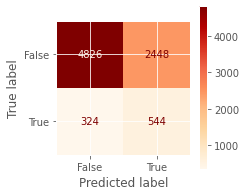

In [50]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

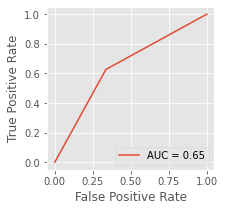

In [51]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# AdaBoost

In [71]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    AdaBoostClassifier(base_estimator=GradientBoostingClassifier(loss='deviance',
                                                                 learning_rate=.1,
                                                                 n_estimators=10,
                                                                 subsample=0.5,
                                                                 n_iter_no_change=10,
                                                                 max_features = 'auto',
                                                                 random_state=42,
                                                                 validation_fraction = 0.2,
                                                                 criterion = 'friedman_mse',
                                                                 max_depth = 5),
                       n_estimators=100,
                       learning_rate=0.1,
                       algorithm='SAMME.R',
                       random_state=42)
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.01809954751131222
recall score: 0.009216589861751152
precision score: 0.5
discrimination results:


# XGBoost

In [72]:
import xgboost as xgb

In [73]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

# with random oversampling
# X_train = df_train_oversampled.drop(target, axis=1)
# y_train = df_train_oversampled[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [74]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    xgb.XGBClassifier(tree_method="auto",
                      eval_metric = 'logloss',
                      subsample = 0.5,
                      scale_pos_weight = 9,
                      objective = 'binary:hinge')
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

/home/yash/.virtualenvs/bootcamp/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:03:57] WARNING: ../src/learner.cc:573: 
Parameters: { "scale_pos_weight" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


f1 score: 0.05417118093174431
recall score: 0.02880184331797235
precision score: 0.45454545454545453
discrimination results:


In [ ]:
#verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [ ]:
plt.rcParams["figure.figsize"] = [3, 3]

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# Balanced Random Forest

In [76]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [77]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [78]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    BalancedRandomForestClassifier(max_depth=None,
                                   random_state=42, 
                                   n_jobs=-1,
                                   n_estimators = 1000,
                                   criterion = 'gini',
                                   bootstrap = True,
                                   max_samples = 0.1,
                                   oob_score = True,
                                   class_weight = 'balanced',
                                   sampling_strategy = 'majority',
                                   replacement = True),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.276394422310757
recall score: 0.6394009216589862
precision score: 0.17630241423125795
discrimination results:


In [ ]:
#verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [ ]:
plt.rcParams["figure.figsize"] = [3, 3]

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# RUSBoost

In [79]:
from imblearn.ensemble import RUSBoostClassifier

In [80]:
# # without random oversampling
X_train = df_train.drop(target, axis=1)
y_train = df_train[target]

#test data
X_test = df_test.drop(target, axis=1)
y_test = df_test[target]

In [81]:
pipeline = make_pipeline(
    ColumnConverter(), #Does quick clean up, assigns datatypes and categories
    custom_oe(), #Handles encoding of ordinal variable
    SelectColumns(cols=selected_features),
    preprocessor, #uses preprocessor defined above
    RUSBoostClassifier(base_estimator=RandomForestClassifier(max_depth=10,
                                      class_weight="balanced",
                                      random_state=42, n_jobs=-1,
                                      n_estimators = 100,
                                      criterion = 'gini',
                                      max_features = 'auto',
                                      bootstrap = False),
                       n_estimators=100,
                       learning_rate=0.1,
                       algorithm='SAMME.R',
                       sampling_strategy='auto',
                       replacement=False,
                       random_state=42),
)
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.2887945115975171
recall score: 0.5092165898617511
precision score: 0.20155038759689922
discrimination results:


In [ ]:
#verify_no_discrimination_2(X_test=X_test, y_true=y_test, y_pred=y_pred, sensitive_columns = ['medical_specialty', 'payer_code','gender','race', 'age', 'admission_source_code'])

In [ ]:
plt.rcParams["figure.figsize"] = [3, 3]

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=None)
display.plot()
plt.show()

# SMOTE before gbc

In [86]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipe

In [93]:
pipeline = imbpipe([
    ('cleanup_and_prepare', ColumnConverter()),
    ('ordinal', custom_oe()),
    ('feature_select', SelectColumns(cols=selected_features)),
    ('preprocessor', preprocessor),
    ('sampling', SMOTE(random_state=42, k_neighbors = 200)),
    ('classifier', GradientBoostingClassifier(loss='deviance',
                               learning_rate=.1,
                               n_estimators=100,
                               subsample=0.5,
                               n_iter_no_change=10,
                               max_features = 'auto',
                               random_state=42,
                               validation_fraction = 0.2,
                               criterion = 'friedman_mse',
                               max_depth = 5)),
])
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print("f1 score: %s" % (f1_score(y_test, y_pred)))
print("recall score: %s" % (recall_score(y_test, y_pred)))
print("precision score: %s" % (precision_score(y_test, y_pred)))
print("discrimination results:")

f1 score: 0.022598870056497175
recall score: 0.01152073732718894
precision score: 0.5882352941176471
discrimination results:


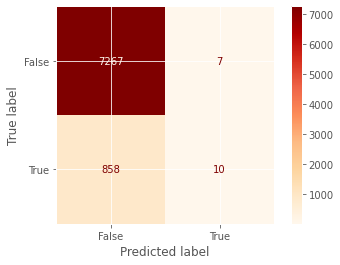

In [94]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels = pipeline.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
disp.plot(cmap="OrRd");

# Output files (pickling)

In [ ]:
# TMP_DIR = '/tmp'
# with open(os.path.join(TMP_DIR, "columns.json"), 'w') as fh:
#     json.dump(X_train.columns.tolist(), fh)

# with open(os.path.join(TMP_DIR, "dtypes.pickle"), 'wb') as fh:
#     pickle.dump(X_train.dtypes, fh)
    
# joblib.dump(pipeline, os.path.join(TMP_DIR, 'pipeline.pickle')) 